# Project 1 — Event Study Starter (Tariff Sentiment x CAR)

This notebook builds the **event-study skeleton**:
1) load CRSP prices, FF5 factors, and earnings announcement meta;
2) align announcement timestamps to trading days;
3) compute market-model / FF5 abnormal returns and CAR for common windows;
4) (preview) hook points for tariff-sentiment to merge later.

**Files expected in the working directory:**
- `crsp_daily.csv` (daily returns)
- `FF5.csv` (Fama–French 5 factors with RF)
- `sp500_10q_meta.csv` (press release timestamps)
- `press_releases_sp500.csv` (optional text)

Feel free to rename paths in the next cell if your files live elsewhere.

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pathlib import Path

import re, math, numpy as np, pandas as pd
from collections import Counter
import xlrd


In [108]:
def parse_any_datetime(s):
    if pd.isna(s):
        return pd.NaT
    try:
        return pd.to_datetime(s, utc=False, errors='coerce')
    except Exception:
        return pd.NaT

def to_trading_day(date_series, trading_calendar):
    """Map arbitrary dates to nearest next available trading day in CRSP calendar."""
    td = trading_calendar
    td = pd.Index(td)
    result = []
    for d in pd.to_datetime(date_series).dt.normalize():
        if d in td:
            result.append(d)
        else:
            # move forward until found
            x = d
            for _ in range(10):
                x = x + pd.Timedelta(days=1)
                if x in td:
                    result.append(x)
                    break
            else:
                result.append(pd.NaT)
    return pd.to_datetime(pd.Series(result))

def detect_columns(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

In [140]:
crsp = pd.read_csv("crsp_daily_extended.csv")
ff5 = pd.read_csv("FF5_extended.csv")
pr_8k_meta = pd.read_csv("press_releases_meta.csv")

    # --- CRSP ---
if crsp is not None:
    date_col = detect_columns(crsp, ['date', 'caldt', 'dt'])
    ret_col  = detect_columns(crsp, ['RET', 'return', 'retadj', 'dlret'])
    id_col   = detect_columns(crsp, ['permno', 'permco', 'id', 'TICKER', 'ticker', 'symbol'])
    if date_col is None or ret_col is None or id_col is None:
        raise ValueError('Please make sure crsp has date/ret/id columns (date, ret, permno|ticker).')
    crsp = crsp.rename(columns={date_col:'date', ret_col:'ret', id_col:'id'})
    crsp['date'] = pd.to_datetime(crsp['date']).dt.normalize()
    crsp = crsp.sort_values(['id','date'])
    # ensure returns are numeric
    crsp['ret'] = pd.to_numeric(crsp['ret'], errors='coerce')

# --- FF5 ---
if ff5 is not None:
    ff_date = detect_columns(ff5, ['date','caldt','dt'])
    rf_col  = detect_columns(ff5, ['rf'])
    mktrf   = detect_columns(ff5, ['mktrf', 'mkt_rf', 'mkt-rf'])
    if ff_date is None or rf_col is None or mktrf is None:
        raise ValueError('FF5 must have date, mktrf, rf.')
    ff5 = ff5.rename(columns={ff_date:'date', mktrf:'mktrf', rf_col:'rf'})
    ff5['date'] = pd.to_datetime(ff5['date']).dt.normalize()

# --- META (announcement timestamps) ---
if pr_8k_meta is not None:
    firm_col = detect_columns(pr_8k_meta, ['ticker','symbol','permno','permco','id'])
    ts_col   = detect_columns(pr_8k_meta, ['ann_time','acceptanceDateTime','press_release_time','timestamp'])
    if firm_col is None or ts_col is None:
        raise ValueError('sp500_8k_meta.csv must have firm id (ticker) and announcement timestamp columns.')
    pr_8k_meta = pr_8k_meta.rename(columns={firm_col:'id', ts_col:'ann_time'})
    pr_8k_meta['ann_time'] = pd.to_datetime(pr_8k_meta['ann_time'], errors='coerce')
    # derive natural day and after-hours flag
    pr_8k_meta['ann_date'] = pr_8k_meta['ann_time'].dt.normalize()
    pr_8k_meta['after_hours'] = pr_8k_meta['ann_time'].dt.hour >= 16  # rough rule
    display(pr_8k_meta[['id','ann_time','after_hours']].head())

/var/folders/rz/k6n0mj6j3xb2f99r3dqnqjbc0000gn/T/ipykernel_27971/1247342443.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  crsp = pd.read_csv("crsp_daily_extended.csv")


,id,ann_time,after_hours
0,A,2025-08-27 20:06:24,True
1,A,2025-05-28 20:06:14,True
2,A,2025-02-26 21:05:37,True
3,A,2024-11-25 21:06:14,True
4,A,2024-08-21 20:06:43,True


In [110]:
def to_trading_day(date_series, trading_calendar, max_days=20):
    """Map arbitrary dates to nearest next available trading day in CRSP calendar."""
    td = pd.Index(trading_calendar)
    result = []
    problematic_dates = []
    
    for i, d in enumerate(pd.to_datetime(date_series).dt.normalize()):
        if pd.isna(d):
            result.append(pd.NaT)
            continue
            
        if d in td:
            result.append(d)
        else:
            # move forward until found
            x = d
            found = False
            for days_forward in range(1, max_days + 1):
                x = d + pd.Timedelta(days=days_forward)
                if x in td:
                    result.append(x)
                    found = True
                    break
            
            if not found:
                result.append(pd.NaT)
                problematic_dates.append((i, d, d + pd.Timedelta(days=max_days)))
    
    if problematic_dates:
        print(f"Warning: {len(problematic_dates)} dates couldn't be mapped to trading days")
        print(f"Sample problematic dates (idx, date, search_end): {problematic_dates[:5]}")
        
    return pd.to_datetime(pd.Series(result))

In [111]:
if (crsp is not None) and (pr_8k_meta is not None):
    trading_days = crsp['date'].drop_duplicates().sort_values().tolist()
    trading_days = pd.to_datetime(trading_days)
    
    # Check trading days range for debugging
    print(f"Trading days range: {trading_days[0]} to {trading_days[-1]}")
    
    # Filter press releases to dates within or close to CRSP date range
    min_date = trading_days[0] - pd.Timedelta(days=30)  # Allow some buffer
    max_date = trading_days[-1] + pd.Timedelta(days=30)
    
    # Count out-of-range dates before filtering
    out_of_range = ((pr_8k_meta['ann_date'] < min_date) | 
                    (pr_8k_meta['ann_date'] > max_date)).sum()
    print(f"Found {out_of_range} press releases outside trading day range ±30 days")
    
    if out_of_range > 0:
        # Only filter if we need to
        original_count = len(pr_8k_meta)
        pr_8k_meta = pr_8k_meta[(pr_8k_meta['ann_date'] >= min_date) & 
                               (pr_8k_meta['ann_date'] <= max_date)].copy()
        print(f"Filtered dataset from {original_count} to {len(pr_8k_meta)} records")

    # if after-hours, shift to next trading day
    pr_8k_meta['t0'] = pr_8k_meta['ann_date']
    mask = pr_8k_meta['after_hours'].fillna(False)
    pr_8k_meta.loc[mask, 't0'] = pr_8k_meta.loc[mask, 't0'] + pd.Timedelta(days=1)
    
    # Use enhanced to_trading_day with more days to search
    pr_8k_meta['t0'] = to_trading_day(pr_8k_meta['t0'], trading_days, max_days=20)
    
    # Check how many NaT values remain
    nat_count = pr_8k_meta['t0'].isna().sum()
    print(f"Records with NaT t0 values: {nat_count} ({nat_count/len(pr_8k_meta)*100:.2f}%)")
    
    # Display problematic records for investigation
    if nat_count > 0:
        print("Sample problematic records:")
        display(pr_8k_meta[pr_8k_meta['t0'].isna()][['id','ann_time','ann_date','after_hours']].head())
    
    display(pr_8k_meta[['id','ann_time','after_hours','t0']].head())

Trading days range: 2022-01-03 00:00:00 to 2025-09-24 00:00:00
Found 0 press releases outside trading day range ±30 days
Records with NaT t0 values: 0 (0.00%)


,id,ann_time,after_hours,t0
0,A,2025-08-27 20:06:24,True,2025-08-28
1,A,2025-05-28 20:06:14,True,2025-05-29
2,A,2025-02-26 21:05:37,True,2025-02-27
3,A,2024-11-25 21:06:14,True,2024-11-26
4,A,2024-08-21 20:06:43,True,2024-08-22


In [ ]:
# ====== A) 读入本地 earning call transcripts → df_sents ======
import os, re, glob, html
import pandas as pd
import numpy as np

BASE_DIR = "/Users/sally/Desktop/Fall2025/NLP/Project_1/sp500_transcripts"  # 你的根目录
# 子目录示例：A_2024_Q1 / ...；文件最好是 .txt 或 .html（若是pdf请先转文本）

# --- 简单清洗与切句 ---
sent_splitter = re.compile(r'(?<=[\.\?\!])\s+')
def clean_text(x:str) -> str:
    if not isinstance(x, str): return ""
    x = html.unescape(x)
    # 去除 html 标签
    x = re.sub(r'<[^>]+>', ' ', x)
    x = re.sub(r'\s+', ' ', x).strip()
    return x

def split_sentences(text:str):
    if not text: return []
    sents = sent_splitter.split(text)
    return [s.strip() for s in sents if len(s.strip())>2]

# --- 从路径/文件名中推断 ticker & quarter ---
# 允许两种来源：父目录名 "A_2024_Q1" 或 文件名内 "A_2024_Q1_*.txt"
pat_dir = re.compile(r'([A-Z]{1,6})_(\d{4})_Q([1-4])', re.I)
pat_file = re.compile(r'([A-Z]{1,6})_(\d{4})_Q([1-4])', re.I)

def parse_meta_from_path(fp:str):
    # 优先从父目录
    dname = os.path.basename(os.path.dirname(fp))
    m = pat_dir.search(dname)
    if not m:
        fname = os.path.basename(fp)
        m = pat_file.search(fname)
    if m:
        tic = m.group(1).upper()
        yr = int(m.group(2)); q = int(m.group(3))
        fq = f"{yr}Q{q}"
        return tic, fq
    # 兜底：只给 ticker（取上级目录名首段）
    parts = dname.split('_')
    tic = parts[0].upper() if parts else 'UNK'
    return tic, None

# --- Heuristic：划分 Prepared vs Q&A ---
# 常见分隔标记：Question-and-Answer / Q&A / Operator: "We will now begin the Q&A session" 等
qa_boundary_re = re.compile(r'(question[-\s]*and[-\s]*answer|q\s*&\s*a|q\/a|q and a)', re.I)
def split_prepared_qna(text:str):
    # 返回 dict {'prep': str, 'qna': str}
    text = clean_text(text)
    if not text: return {'prep':"", 'qna':""}
    # 先按 Q&A 标记切
    m = qa_boundary_re.search(text)
    if not m:
        # 若无法识别，全部归为 prepared
        return {'prep': text, 'qna': ""}
    idx = m.start()
    return {'prep': text[:idx].strip(), 'qna': text[idx:].strip()}

# --- 扫描目录读取文本 ---
def load_transcripts(base_dir:str, patterns=(".txt",".html",".htm")):
    files = []
    for ext in patterns:
        files.extend(glob.glob(os.path.join(base_dir, "**", f"*{ext}"), recursive=True))
    rows = []
    for fp in files:
        try:
            with open(fp, 'r', encoding='utf-8', errors='ignore') as f:
                raw = f.read()
        except Exception:
            # 有些 html 可能需要二次打开方式
            try:
                with open(fp, 'rb') as f:
                    raw = f.read().decode('utf-8', 'ignore')
            except Exception:
                continue
        ticker, fq = parse_meta_from_path(fp)
        parts = split_prepared_qna(raw)
        for part_name in ['prep','qna']:
            txt = parts.get(part_name,"")
            if not txt: 
                continue
            for s in split_sentences(txt):
                rows.append({
                    'ticker': ticker,
                    'fiscal_quarter': fq,
                    'source_txt': 'call',    # 本批是电话
                    'part': part_name,       # 'prep' or 'qna'
                    'sentence': s
                })
    return pd.DataFrame(rows)

df_sents = load_transcripts(BASE_DIR)
# 可选：丢弃缺少季度的信息（若路径里没 Q 信息就先保留，后面可用事件时间反推）
print("df_sents shape:", df_sents.shape)
print(df_sents.head(3))
# df_sents.to_parquet('/tmp/df_sents_calls.parquet')  # 可选缓存


## 4) Build event windows and compute CARs

In [113]:
def get_window(d, k):
    # given date d and integer offsets in k (e.g., range(-1,2)) build date list
    return [d + pd.Timedelta(days=int(x)) for x in k]

def compute_car_for_event(df_crsp, df_ff5, firm_id, t0, window=(-1,1), debug=False):
    """
    Compute cumulative abnormal returns for an event with improved error handling.
    
    Parameters:
    - df_crsp: CRSP dataframe with stock returns
    - df_ff5: FF5 dataframe with factors
    - firm_id: Identifier for the firm
    - t0: Event date
    - window: Tuple of (start_offset, end_offset) in days relative to t0
    - debug: If True, print debugging information
    
    Returns:
    - Cumulative abnormal return or np.nan if calculation not possible
    """
    if pd.isna(t0):
        if debug: print(f"Event date is NaT for firm {firm_id}")
        return np.nan
        
    start = t0 + pd.Timedelta(days=window[0])
    end = t0 + pd.Timedelta(days=window[1])
    rng = pd.date_range(start, end, freq='D')
    
    if debug: print(f"Firm: {firm_id}, Event: {t0}, Window: {start} to {end}")
    
    # Get CRSP data for this firm and date range
    sub = df_crsp[(df_crsp['id']==firm_id) & (df_crsp['date'].isin(rng))].copy()
    
    if sub.empty:
        if debug: print(f"No CRSP data found for firm {firm_id} in range {start} to {end}")
        return np.nan
        
    if debug: print(f"Found {len(sub)} CRSP records for firm {firm_id}")
    
    # Check if returns exist and are numeric
    if sub['ret'].isna().all():
        if debug: print(f"All returns are NaN for firm {firm_id}")
        return np.nan
    
    # Merge with FF5 factors
    sub = sub.merge(df_ff5[['date','mktrf','rf']], on='date', how='left')
    
    # Check if merge was successful
    if sub['mktrf'].isna().all() or sub['rf'].isna().all():
        if debug: print(f"Missing FF5 data after merge for firm {firm_id}")
        return np.nan
        
    # Calculate abnormal returns
    sub['excess'] = sub['ret'] - (sub['rf']/100.0)
    sub['abret'] = sub['excess'] - (sub['mktrf']/100.0)
    
    return sub['abret'].sum()



In [114]:
def get_window(d, k):
    # given date d and integer offsets in k (e.g., range(-1,2)) build date list
    return [d + pd.Timedelta(days=int(x)) for x in k]

def compute_car_for_event(df_crsp, df_ff5, firm_id, t0, window=(-1,1)):
    if pd.isna(t0):
        return np.nan
    start = t0 + pd.Timedelta(days=window[0])
    end   = t0 + pd.Timedelta(days=window[1])
    rng = pd.date_range(start, end, freq='D')
    sub = df_crsp[(df_crsp['id']==firm_id) & (df_crsp['date'].isin(rng))].copy()
    if sub.empty:
        return np.nan
    sub = sub.merge(df_ff5[['date','mktrf','rf']], on='date', how='left')
    # Excess return ~ ret - rf; abnormal ~ (ret - rf) - mktrf  (market model)
    sub['excess'] = sub['ret'] - (sub['rf']/100.0)
    sub['abret']  = sub['excess'] - (sub['mktrf']/100.0)
    return sub['abret'].sum()

def compute_car_with_fallback(df_crsp, df_ff5, firm_id, t0):
    """Compute CAR with fallback windows: (-1,1) -> (0,2) -> (0,1)"""
    # Try primary window (-1,1)
    car = compute_car_for_event(df_crsp, df_ff5, firm_id, t0, (-1,1))
    if not pd.isna(car):
        return car, '(-1,1)'
    
    # Try secondary window (0,2)  
    car = compute_car_for_event(df_crsp, df_ff5, firm_id, t0, (0,2))
    if not pd.isna(car):
        return car, '(0,2)'
    
    # Try fallback window (0,1)
    car = compute_car_for_event(df_crsp, df_ff5, firm_id, t0, (0,1))
    if not pd.isna(car):
        return car, '(0,1)'
    
    return np.nan, 'failed'

if (crsp is not None) and (ff5 is not None) and (pr_8k_meta is not None):
    # Apply the fallback strategy
    results = pr_8k_meta.apply(lambda r: compute_car_with_fallback(crsp, ff5, r['id'], r['t0']), axis=1)
    pr_8k_meta['car_final'] = [result[0] for result in results]
    pr_8k_meta['car_window'] = [result[1] for result in results]
    
    # Also keep the original calculations for comparison
    pr_8k_meta['car_mkt_-1_+1'] = pr_8k_meta.apply(lambda r: compute_car_for_event(crsp, ff5, r['id'], r['t0'], (-1,1)), axis=1)
    pr_8k_meta['car_mkt_0_+2']  = pr_8k_meta.apply(lambda r: compute_car_for_event(crsp, ff5, r['id'], r['t0'], (0,2)), axis=1)
    
    # Show summary of window usage
    window_counts = pr_8k_meta['car_window'].value_counts()
    print("Window usage summary:")
    for window, count in window_counts.items():
        print(f"  {window}: {count} events ({count/len(pr_8k_meta):.1%})")
    
    # Calculate NaN percentages after fallback process
    total_events = len(pr_8k_meta)
    nan_final = pr_8k_meta['car_final'].isna().sum()
    nan_original_11 = pr_8k_meta['car_mkt_-1_+1'].isna().sum()
    nan_original_02 = pr_8k_meta['car_mkt_0_+2'].isna().sum()
    
    print(f"\nNaN Analysis:")
    print(f"  Total events: {total_events}")
    print(f"  Original (-1,+1) NaN: {nan_original_11} ({nan_original_11/total_events:.1%})")
    print(f"  Original (0,+2) NaN: {nan_original_02} ({nan_original_02/total_events:.1%})")
    print(f"  Final CAR NaN (after fallback): {nan_final} ({nan_final/total_events:.1%})")
    print(f"  Data recovery: {nan_original_11 - nan_final} events saved by fallback strategy")
    
    display(pr_8k_meta[['id','ann_time','t0','car_final','car_window','car_mkt_-1_+1','car_mkt_0_+2']].head())

Window usage summary:
  (-1,1): 2120 events (99.3%)
  failed: 15 events (0.7%)

NaN Analysis:
  Total events: 2135
  Original (-1,+1) NaN: 15 (0.7%)
  Original (0,+2) NaN: 15 (0.7%)
  Final CAR NaN (after fallback): 15 (0.7%)
  Data recovery: 0 events saved by fallback strategy


,id,ann_time,t0,car_final,car_window,car_mkt_-1_+1,car_mkt_0_+2
0,A,2025-08-27 20:06:24,2025-08-28,0.000000,"(-1,1)",0.000000,0.000000
1,A,2025-05-28 20:06:14,2025-05-29,0.000000,"(-1,1)",0.000000,0.000000
2,A,2025-02-26 21:05:37,2025-02-27,0.000000,"(-1,1)",0.000000,0.000000
3,A,2024-11-25 21:06:14,2024-11-26,0.031973,"(-1,1)",0.031973,0.027159
4,A,2024-08-21 20:06:43,2024-08-22,0.007905,"(-1,1)",0.007905,0.006242


## 5) Quick sanity check on one firm

Sample firm: ADSK  event t0=2024-11-27


,date,ret,excess,abret
0,2024-11-22,0.018579,0.018577,0.018524
1,2024-11-25,-0.005852,-0.005854,-0.005895
2,2024-11-26,-0.004477,-0.004479,-0.004521
3,2024-11-27,-0.085923,-0.085925,-0.085885
4,2024-11-29,0.004335,0.004333,0.004279
5,2024-12-02,0.016273,0.016271,0.016248


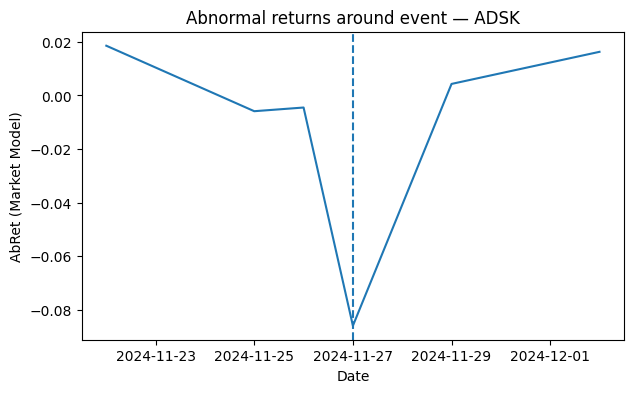

In [115]:
if (crsp is not None) and (ff5 is not None) and (pr_8k_meta is not None):
    # pick a firm with at least one mapped t0
    samp = pr_8k_meta.dropna(subset=['t0']).iloc[101] 
    firm = samp['id']
    t0   = samp['t0']
    rng = pd.date_range(t0-pd.Timedelta(days=5), t0+pd.Timedelta(days=5), freq='D')
    sub = crsp[(crsp['id']==firm) & (crsp['date'].isin(rng))].merge(ff5[['date','mktrf','rf']], on='date', how='left')
    sub = sub.sort_values('date').copy()
    sub['excess'] = sub['ret'] - (sub['rf']/100.0)
    sub['abret']  = sub['excess'] - (sub['mktrf']/100.0)
    print(f"Sample firm: {firm}  event t0={t0.date()}")
    display(sub[['date','ret','excess','abret']])
    # Plot abnormal returns around event
    plt.figure(figsize=(7,4))
    plt.axvline(t0, linestyle='--')
    plt.plot(sub['date'], sub['abret'])
    plt.title(f'Abnormal returns around event — {firm}')
    plt.xlabel('Date'); plt.ylabel('AbRet (Market Model)')
    plt.show()

In [185]:
pr_8k_meta.to_csv("/Users/sally/Desktop/Fall2025/NLP/Project_1/results/pr_8k_meta.csv", index=False)

## 6) Save panel for later regression
We keep CARs and announcement metadata as an intermediate table. Later we will merge **tariff sentiment** and **EPS surprise**.

In [116]:
if pr_8k_meta is not None:
    out = pr_8k_meta.copy()
    out_path = Path('events_panel.parquet')
    try:
        out.to_parquet(out_path, index=False)
        print('Saved →', out_path)
    except Exception as e:
        print('Parquet save failed, falling back to CSV:', e)
        out_path = Path('events_panel.csv')
        out.to_csv(out_path, index=False)
        print('Saved →', out_path)
    out.head()

Saved → events_panel.parquet


 # Project 1 — Tariff Sentiment + EPS Surprise → CAR (Regression)
This notebook continues from `events_panel.parquet` and adds:
1. **Tariff-specific sentiment** extracted from press releases (rule-based, offline)
2. **EPS surprise** computed from your `eps_forecast_vs_actual_*` file
3. Merge to event panel and run an OLS with quarter fixed effects and firm-clustered SEs.

**Inputs expected in working directory** (rename paths if needed):\n",
- `events_panel.parquet` (created by the starter notebook)\n",
- `press_releases_sp500.csv` (cols: firm id + date + text)\n",
- `eps_forecast_vs_actual_*` (inner/outer merged file; must have firm id, fiscal period, actual, forecast)\n",

You can later swap the rule-based sentiment with FinBERT/your own model without changing the aggregation/merge interfaces."


In [ ]:
#pip install statsmodels

  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 8.7 MB/s  0:00:01 eta 0:00:01
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]
Note: you may need to restart the kernel to use updated packages.


In [117]:
import pandas as pd, numpy as np, re
from pathlib import Path
import statsmodels.api as sm
import statsmodels.formula.api as smf
pd.set_option('display.max_columns', 120)

## 1) Load base panel & auxiliary data

In [118]:
events_path = Path('events_panel.parquet')
if not events_path.exists():
    events_path = Path('events_panel.csv')
panel = pd.read_parquet(events_path) if events_path.suffix=='.parquet' else pd.read_csv(events_path)
panel.columns = [c.lower() for c in panel.columns]
panel['t0'] = pd.to_datetime(panel['t0'])
panel['quarter'] = panel['t0'].dt.to_period('Q').astype(str)
id_col = 'id' if 'id' in panel.columns else ('ticker' if 'ticker' in panel.columns else 'symbol')
print('Panel shape:', panel.shape)
panel.head()

Panel shape: (2135, 21)


,cik,form,filingdate,ann_time,reportdate,accessionnumber,primarydocument,primarydocdescription,indexjson,docurl,exhibit99url,itemsraw,id,ann_date,after_hours,t0,car_final,car_window,car_mkt_-1_+1,car_mkt_0_+2,quarter
0,1090872,8-K,2025-08-27,2025-08-27 20:06:24,2025-08-27,0001090872-25-000034,a-20250827.htm,8-K,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...,NaN,"2.02,9.01",A,2025-08-27,True,2025-08-28,0.000000,"(-1,1)",0.000000,0.000000,2025Q3
1,1090872,8-K,2025-05-28,2025-05-28 20:06:14,2025-05-28,0001090872-25-000013,a-20250528.htm,8-K,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...,NaN,"2.02,9.01",A,2025-05-28,True,2025-05-29,0.000000,"(-1,1)",0.000000,0.000000,2025Q2
2,1090872,8-K,2025-02-26,2025-02-26 21:05:37,2025-02-26,0001090872-25-000003,a-20250226.htm,8-K,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...,NaN,"2.02,9.01",A,2025-02-26,True,2025-02-27,0.000000,"(-1,1)",0.000000,0.000000,2025Q1
3,1090872,8-K,2024-11-25,2024-11-25 21:06:14,2024-11-25,0001090872-24-000042,a-20241125.htm,8-K,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...,NaN,"2.02,9.01",A,2024-11-25,True,2024-11-26,0.031973,"(-1,1)",0.031973,0.027159,2024Q4
4,1090872,8-K,2024-08-21,2024-08-21 20:06:43,2024-08-21,0001090872-24-000024,a-20240821.htm,8-K,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...,NaN,"2.02,9.01",A,2024-08-21,True,2024-08-22,0.007905,"(-1,1)",0.007905,0.006242,2024Q3


In [184]:
panel.to_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/events_panel_calledPanel.csv', index=False) if panel is not None else None

## 2) Tariff-specific sentiment from press releases (rule-based)

In [119]:
def read_press(path='/Users/sally/Desktop/Fall2025/NLP/Project_1/build_press_corpus/press_releases_sp500.csv'):
    p = Path(path)
    if not p.exists():
        alt = list(Path('.').glob('press_releases*.csv'))
        if alt:
            p = alt[0]
        else:
            print('⚠️ No press release CSV found. Skipping tariff sentiment...')
            return None
    
    # 首先检查CSV文件的列结构
    df = pd.read_csv(p)
    print(f"Original columns: {list(df.columns)}")
    
    df.columns = [c.lower() for c in df.columns]
    print(f"Lowercased columns: {list(df.columns)}")
    
    # 检查是否同时有id和ticker列
    has_id = 'id' in df.columns
    has_ticker = 'ticker' in df.columns
    
    if has_id and has_ticker:
        print("Both 'id' and 'ticker' columns found. Using 'ticker' column.")
        idc = 'ticker'
    elif has_ticker:
        idc = 'ticker'
    elif has_id:
        idc = 'id'
    else:
        # 如果既没有id也没有ticker，尝试其他标识符
        idc = next((c for c in ['symbol','permno'] if c in df.columns), None)
    
    txt = next((c for c in ['text','body','content'] if c in df.columns), None)
    dte = next((c for c in ['date','ann_date','timestamp'] if c in df.columns), None)
    
    print(f"Detected columns: identifier={idc}, text={txt}, date={dte}")
    
    if not all([idc, txt, dte]):
        print("Available columns that might contain identifier info:", [c for c in df.columns if 'tick' in c or 'symb' in c or 'id' in c])
        print("Available columns that might contain text info:", [c for c in df.columns if 'text' in c or 'body' in c or 'content' in c])
        print("Available columns that might contain date info:", [c for c in df.columns if 'date' in c or 'time' in c])
        raise ValueError('press release file must have identifier (ticker/id), date, and text columns')
    
    # 重命名为ticker列，无论原来是什么
    df = df.rename(columns={idc:'ticker', txt:'text', dte:'date'})
    df['date'] = pd.to_datetime(df['date']).dt.normalize()
    
    # 如果ticker列是NaN，尝试从text列中提取ticker
    if df['ticker'].isna().all():
        print("Ticker column is all NaN. Attempting to extract ticker from text column...")
        
        # 假设ticker在text的开头，以"-"分隔
        def extract_ticker(text):
            if pd.isna(text):
                return None
            # 提取第一个"-"之前的部分作为ticker
            parts = str(text).split('-')
            if len(parts) > 0:
                ticker = parts[0].strip().upper()
                # 验证ticker格式（通常3-4个字母）
                if len(ticker) >= 2 and len(ticker) <= 5 and ticker.isalpha():
                    return ticker
            return None
        
        df['ticker'] = df['text'].apply(extract_ticker)
        print(f"Extracted tickers. Sample: {df['ticker'].dropna().head(3).tolist()}")
    
    # 显示样本数据以确认
    print(f"Sample data after processing:")
    print(df[['ticker','date','text']].head(3))
    
    return df[['ticker','date','text']]

press = read_press()
press.head() if press is not None else None

Original columns: ['id', 'cik', 'ticker', 'accession', 'date', 'quarter', 'text', 'path']
Lowercased columns: ['id', 'cik', 'ticker', 'accession', 'date', 'quarter', 'text', 'path']
Both 'id' and 'ticker' columns found. Using 'ticker' column.
Detected columns: identifier=ticker, text=text, date=date
Ticker column is all NaN. Attempting to extract ticker from text column...
Extracted tickers. Sample: ['ABT', 'ABT', 'ABT']
Sample data after processing:
  ticker       date                                               text
0    ABT 2023-01-25  abt-20230125 0000001800 FALSE New York Stock E...
1    ABT 2023-07-20  abt-20230720 0000001800 FALSE New York Stock E...
2    ABT 2023-04-19  abt-20230419 0000001800 FALSE New York Stock E...


,ticker,date,text
0,ABT,2023-01-25,abt-20230125 0000001800 FALSE New York Stock E...
1,ABT,2023-07-20,abt-20230720 0000001800 FALSE New York Stock E...
2,ABT,2023-04-19,abt-20230419 0000001800 FALSE New York Stock E...
3,ABT,2023-10-18,abt-20231018 0000001800 FALSE New York Stock E...
4,ABT,2024-01-24,abt-20240124 0000001800 FALSE New York Stock E...


In [183]:
press.to_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/press.csv', index=False) if press is not None else None

### Tariff lexicon &  polarity lexicon

In [157]:
# 读入 master dictionary
master = pd.read_csv("/Users/sally/Desktop/Fall2025/NLP/Project_1/Loughran-McDonald_MasterDictionary_1993-2024.csv")

# 标准化列名（以防有大小写差异）
master.columns = master.columns.str.strip().str.lower()

# 提取不同类别的词表
neg_words = set(master.loc[master['negative'] > 0, 'word'].str.lower())
pos_words = set(master.loc[master['positive'] > 0, 'word'].str.lower())
uncertainty_words = set(master.loc[master['uncertainty'] > 0, 'word'].str.lower())
litigious_words = set(master.loc[master['litigious'] > 0, 'word'].str.lower())
strong_modal = set(master.loc[master['strong_modal'] > 0, 'word'].str.lower())
weak_modal   = set(master.loc[master['weak_modal'] > 0, 'word'].str.lower())

print("Negative words:", len(neg_words))
print("Positive words:", len(pos_words))

Negative words: 2345
Positive words: 347


In [159]:
# --- 1) 关税词典：修正 \s、加词边界 ---
tariff_terms = [
    r'\btariff\b', r'\btariffs\b', r'\bduty\b', r'\bduties\b', r'\blevy\b', r'\blevies\b', r'\bquota\b',
    r'\bsection\s*301\b', r'\bcountervailing\b', r'\banti-?dumping\b', r'\bimport\s+tax\b', r'\bcustoms\b',
    r'\bdecoupling\b', r'\bretaliatory\b', r'\bexemption\b', r'\bexemptions\b', r'\bexclusion\b', r'\bexclusions\b',
    r'\bharmonized\s+code\b', r'\bhs\s*code\b', r'\btrade\s+war\b', r'\bsection\s*232\b'
]
tariff_re = re.compile('|'.join(tariff_terms), flags=re.IGNORECASE)


# 用短语/高置信 cue，避免 year 过宽触发
fwd_phrase_re = re.compile(r'\b(next\s+(quarter|qtr|year|fy)|guidance|outlook|will)\b', re.IGNORECASE)

# --- 3) 句子分割：修正 \s+ ---
sent_splitter = re.compile(r'(?<=[.!?])\s+')

# --- 4) 细节：把“奇怪连字符”标准化为普通连字符，提升命中率 ---
_dash_fix = str.maketrans({'–':'-', '—':'-', '-':'-'})

def _normalize(text: str) -> str:
    return text.translate(_dash_fix)

def sentence_polarity(s: str) -> float:
    s = _normalize(s)
    tokens = re.findall(r"[a-zA-Z\-']+", s.lower())
    pos = sum(t in pos_words for t in tokens)
    neg = sum(t in neg_words for t in tokens)
    if pos == 0 and neg == 0:
        return 0.0
    return (pos - neg) / max(1, (pos + neg))

def forward_looking(s: str) -> int:
    s = _normalize(s)
    return int(bool(fwd_phrase_re.search(s)))

def extract_tariff_sentences(text):
    if not isinstance(text, str) or not text.strip():
        return []
    text = _normalize(text)
    sents = sent_splitter.split(text.strip())
    return [s for s in sents if tariff_re.search(s)]

def score_doc(text):
    sents = extract_tariff_sentences(text)
    # 可保留/删除这些 print——批处理时建议关掉
    print(f"Found {len(sents)} tariff sentences in text")
    if not sents:
        return {
            'TariffMentions': 0,
            'TariffSent_mean': np.nan,
            'TariffSent_shareNeg': np.nan,
            'TariffSent_fwd': np.nan,     # 统一列名
        }
    pols = [sentence_polarity(s) for s in sents]
    share_neg = float(np.mean([1.0 if p < 0 else 0.0 for p in pols])) if len(pols) else np.nan
    fwd_mask = [forward_looking(s) for s in sents]
    fwd_mean = np.nan if sum(fwd_mask) == 0 else float(np.mean([p for p, m in zip(pols, fwd_mask) if m]))
    return {
        'TariffMentions': len(sents),
        'TariffSent_mean': float(np.mean(pols)),
        'TariffSent_shareNeg': share_neg,
        'TariffSent_fwd': fwd_mean,      # 统一列名
    }


### Score press releases and aggregate by firm–quarter

In [ ]:
if press is not None:
    press['quarter'] = pd.to_datetime(press['date']).dt.to_period('Q').astype(str)
    feats = press['text'].apply(score_doc).apply(pd.Series)
    pr_feat = pd.concat([press[['ticker','quarter']], feats], axis=1)
    agg = pr_feat.groupby(['ticker','quarter']).agg({ # agg has data of tariff sentiment by ticker-quarter
        'TariffMentions':'sum',
        'TariffSent_mean':'mean',
        'TariffSent_shareNeg':'mean',
        'TariffSent_fwd':'mean'  # Corrected from 'TariffSent_fwd_mean' to match the key in score_doc
    }).reset_index()
    agg.head()
else:
    agg = None
    print('No press releases → tariff features unavailable in this run.')

Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 0 tariff sentences in text
Found 2 ta

In [182]:
agg.to_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/agg.csv', index=False) if agg is not None else None

### Dealing with Earning Calls

In [ ]:
# 改为你的 xls 路径（或直接用 /mnt/data/... 你自己放置到可读路径）
CALL_XLS = "/Users/sally/Desktop/Fall2025/NLP/Project_1/earning_call_meta.xls"

# 读取第一个 sheet（如有指定 sheet_name 自行修改）
xls = pd.ExcelFile(CALL_XLS)
df_call_meta = pd.read_excel(xls, sheet_name=0)

# 规范列名
df_call_meta.columns = df_call_meta.columns.str.strip().str.lower()

# 尝试识别公司/代码/时间列（你也可以显式指定列名，避免猜测）
cand_company = next((c for c in ['company','firm','name','issuer'] if c in df_call_meta.columns), None)
cand_ticker  = next((c for c in ['ticker','permno','permco'] if c in df_call_meta.columns), None)
cand_date    = next((c for c in ['calldate','date / time','call_date'] if c in df_call_meta.columns), None)
cand_time    = next((c for c in ['time','calltime','call_time'] if c in df_call_meta.columns), None)
cand_quarter = next((c for c in ['quarter','fiscal_quarter','fq'] if c in df_call_meta.columns), None)

# 组装 ann_time
if cand_date is None:
    raise ValueError("⛔️ call 时间戳数据缺少日期列（例如 CallDate/Date）")
if cand_time is None:
    # 如果没有具体时间，默认设为 16:05（盘后）以更保守
    df_call_meta['ann_time'] = pd.to_datetime(df_call_meta[cand_date]).dt.floor('D') + pd.Timedelta(hours=16, minutes=5)
else:
    df_call_meta['ann_time'] = pd.to_datetime(df_call_meta[cand_date].astype(str) + ' ' + df_call_meta[cand_time].astype(str), errors='coerce')

# 生成 quarter（若原表无）
def quarter_str(dt):
    dt = pd.to_datetime(dt)
    return f"{dt.year}Q{((dt.month-1)//3)+1}"

if cand_quarter is None:
    df_call_meta['quarter'] = df_call_meta['ann_time'].apply(quarter_str)
else:
    df_call_meta['quarter'] = df_call_meta[cand_quarter].astype(str)

# 统一一个 id 列（优先 ticker）
if cand_ticker is not None:
    df_call_meta['id'] = df_call_meta[cand_ticker].astype(str).str.upper().str.strip()
elif cand_company is not None:
    df_call_meta['id'] = df_call_meta[cand_company].astype(str).str.strip()
else:
    raise ValueError("⛔️ call 元数据缺少 ticker/company 等 id 线索")


/var/folders/rz/k6n0mj6j3xb2f99r3dqnqjbc0000gn/T/ipykernel_27971/1715884294.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_call_meta['ann_time'] = pd.to_datetime(df_call_meta[cand_date]).dt.floor('D') + pd.Timedelta(hours=16, minutes=5)


In [207]:
df_call_meta
#df_call_meta.to_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/df_call_meta.csv', index=False)

,date / time,title,type,ticker,ann_time,quarter,id
0,Sep-23-2025 6:00 PM,"Micron Technology, Inc., Q4 2025 Earnings Call...",Earnings Call,MU,2025-09-23 16:05:00,2025Q3,MU
1,Sep-23-2025 4:30 PM,"Micron Technology, Inc., Q4 2025 Earnings Call...",Earnings Call,MU,2025-09-23 16:05:00,2025Q3,MU
2,Sep-23-2025 10:00 AM,"AutoZone, Inc., Q4 2025 Earnings Call, Sep 23,...",Earnings Call,AZO,2025-09-23 16:05:00,2025Q3,AZO
3,Sep-19-2025 11:00 AM,"Lennar Corporation, Q3 2025 Earnings Call, Sep...",Earnings Call,LEN,2025-09-19 16:05:00,2025Q3,LEN
4,Sep-18-2025 5:30 PM,"FedEx Corporation, Q1 2026 Earnings Call, Sep ...",Earnings Call,FDX,2025-09-18 16:05:00,2025Q3,FDX
...,...,...,...,...,...,...,...
3996,Sep-28-2023 8:00 AM,"Accenture plc, Q4 2023 Earnings Call, Sep 28, ...",Earnings Call,ACN,2023-09-28 16:05:00,2023Q3,ACN
3997,Sep-27-2023 4:30 PM,"Micron Technology, Inc., Q4 2023 Earnings Call...",Earnings Call,MU,2023-09-27 16:05:00,2023Q3,MU
3998,Sep-27-2023 9:30 AM,"Paychex, Inc., Q1 2024 Earnings Call, Sep 27, ...",Earnings Call,PAYX,2023-09-27 16:05:00,2023Q3,PAYX
3999,Sep-26-2023 5:00 PM,"Costco Wholesale Corporation, Q4 2023 Earnings...",Earnings Call,COST,2023-09-26 16:05:00,2023Q3,COST


⑤ 事件日锚点（盘后→次一交易日；盘中→当日）+ 构建事件 CAR

用你已有的 compute_car_for_event(crsp, ff5, id, t0, window=(0,1))。这里给一个 t0 推断，用 CRSP 的交易日集合。

In [176]:
# 构建交易日集合（基于你已有的 crsp）
crsp_dates_set = set(pd.to_datetime(pd.to_datetime(crsp['date']).dt.normalize().unique()))

def infer_t0_from_announce_time(ann_time, crsp_dates_set, cutoff_hour=16):
    ts = pd.to_datetime(ann_time)
    d0 = pd.Timestamp(ts.date())
    # 收盘后（>=16:00）
    if ts.hour >= cutoff_hour:
        nxt = d0 + pd.Timedelta(days=1)
        while nxt not in crsp_dates_set:
            nxt += pd.Timedelta(days=1)
        return nxt
    else:
        cur = d0
        while cur not in crsp_dates_set:
            cur += pd.Timedelta(days=1)
        return cur

# 生成事件窗 CAR（[0,+1] 为主，另给 [-1,+1]/[0,+2] 以便稳健性）
def build_call_event_cars(df_call_meta, crsp, ff5):
    out = []
    for _, r in df_call_meta.iterrows():
        fid = r['id']
        if pd.isna(r['ann_time']):
            continue
        t0 = infer_t0_from_announce_time(r['ann_time'], crsp_dates_set)
        car_01 = compute_car_for_event(crsp, ff5, fid, t0, window=(0,1))
        car_11 = compute_car_for_event(crsp, ff5, fid, t0, window=(-1,1))
        car_02 = compute_car_for_event(crsp, ff5, fid, t0, window=(0,2))
        out.append({'id':fid, 't0_call':t0, 'quarter':quarter_str(t0),
                    'CAR_call_0_1':car_01, 'CAR_call_-1_1':car_11, 'CAR_call_0_2':car_02})
    ev = pd.DataFrame(out)
    for c in ['CAR_call_0_1','CAR_call_-1_1','CAR_call_0_2']:
        lo, hi = ev[c].quantile([0.01,0.99])
        ev[c] = ev[c].clip(lo, hi)
    return ev

event_call_panel = build_call_event_cars(df_call_meta, crsp, ff5)
event_call_panel.head()


,id,t0_call,quarter,CAR_call_0_1,CAR_call_-1_1,CAR_call_0_2
0,MU,2025-09-24,2025Q3,0.0,0.0,0.0
1,MU,2025-09-24,2025Q3,0.0,0.0,0.0
2,AZO,2025-09-24,2025Q3,0.0,0.0,0.0
3,LEN,2025-09-22,2025Q3,0.0,0.0,0.0
4,FDX,2025-09-19,2025Q3,0.0,0.0,0.0


#### Get Earning Calls Transcript Data

In [ ]:
call_tariff_panel = pd.read_csv("/Users/sally/Desktop/Fall2025/NLP/Project_1/results/call_tariff_panel.csv")
panel_merge=pd.read_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/panel_merge.csv')


,id,quarter,ann_time,t0,source_txt,TariffMentions_call_all,TariffSent_mean_call_all,TariffSent_shareNeg_call_all,TariffSent_fwd_call_all,TariffMentions_call_prep,TariffSent_mean_call_prep,TariffSent_shareNeg_call_prep,TariffSent_fwd_call_prep,TariffMentions_call_qna,TariffSent_mean_call_qna,TariffSent_shareNeg_call_qna,TariffSent_fwd_call_qna
0,AAPL,2025Q3,NaN,NaN,AAPL_2025_Q3.txt,21,-0.105263,0.105263,-0.25,21,-0.105263,0.105263,-0.25,0,0.0,0.0,0.0
1,ABNB,2025Q1,NaN,NaN,ABNB_2025_Q1.txt,0,0.000000,0.000000,0.00,0,0.000000,0.000000,0.00,0,0.0,0.0,0.0
2,ABBV,2025Q1,NaN,NaN,ABBV_2025_Q1.txt,23,-0.150000,0.150000,-0.50,23,-0.150000,0.150000,-0.50,0,0.0,0.0,0.0
3,ABNB,2024Q3,NaN,NaN,ABNB_2024_Q3.txt,0,0.000000,0.000000,0.00,0,0.000000,0.000000,0.00,0,0.0,0.0,0.0
4,AAPL,2024Q2,NaN,NaN,AAPL_2024_Q2.txt,0,0.000000,0.000000,0.00,0,0.000000,0.000000,0.00,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142,ZTS,2024Q3,NaN,NaN,ZTS_2024_Q3.txt,0,0.000000,0.000000,0.00,0,0.000000,0.000000,0.00,0,0.0,0.0,0.0
3143,ZTS,2024Q1,NaN,NaN,ZTS_2024_Q1.txt,0,0.000000,0.000000,0.00,0,0.000000,0.000000,0.00,0,0.0,0.0,0.0
3144,ZTS,2024Q4,NaN,NaN,ZTS_2024_Q4.txt,1,-1.000000,1.000000,-1.00,1,-1.000000,1.000000,-1.00,0,0.0,0.0,0.0
3145,ZTS,2025Q2,NaN,NaN,ZTS_2025_Q2.txt,9,-0.375000,0.375000,-0.50,9,-0.375000,0.375000,-0.50,0,0.0,0.0,0.0


In [221]:
#panel_merge.drop(columns=['accessionnumber','primarydocument','indexjson','docurl',], inplace=True)
panel_merge.drop(columns=['cik','form','filingdate','primarydocdescription','exhibit99url'], inplace=True)

In [222]:
panel_merge

,ann_time,reportdate,itemsraw,ticker,ann_date,after_hours,t0,car_mkt_-1_+1,car_mkt_0_+1,car_mkt_0_+2,car_final,car_window,quarter,TariffMentions,TariffSent_mean,TariffSent_shareNeg,TariffSent_fwd_mean,surprise_pct,sue_z
0,2025-08-27 20:06:24,2025-08-27,"2.02,9.01",A,2025-08-27,True,2025-08-28,0.000000,0.000000,0.000000,0.000000,"(-1,1)",2025Q3,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-05-28 20:06:14,2025-05-28,"2.02,9.01",A,2025-05-28,True,2025-05-29,0.000000,0.000000,0.000000,0.000000,"(-1,1)",2025Q2,NaN,NaN,NaN,NaN,-0.050269,-0.041543
2,2025-02-26 21:05:37,2025-02-26,"2.02,9.01",A,2025-02-26,True,2025-02-27,0.000000,0.000000,0.000000,0.000000,"(-1,1)",2025Q1,NaN,NaN,NaN,NaN,-0.050269,-0.057802
3,2024-11-25 21:06:14,2024-11-25,"2.02,9.01",A,2024-11-25,True,2024-11-26,0.031973,0.027159,0.027159,0.031973,"(-1,1)",2024Q4,NaN,NaN,NaN,NaN,0.038168,0.031690
4,2024-08-21 20:06:43,2024-08-21,"2.02,9.01",A,2024-08-21,True,2024-08-22,0.007905,0.006242,0.006242,0.007905,"(-1,1)",2024Q3,NaN,NaN,NaN,NaN,0.046154,-0.001481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2130,2024-11-07 21:13:34,2024-11-07,"2.02,9.01",XYZ,2024-11-07,True,2024-11-08,NaN,NaN,NaN,NaN,failed,2024Q4,NaN,NaN,NaN,NaN,NaN,NaN
2131,2024-08-01 20:16:55,2024-08-01,"2.02,8.01,9.01",XYZ,2024-08-01,True,2024-08-02,NaN,NaN,NaN,NaN,failed,2024Q3,NaN,NaN,NaN,NaN,NaN,NaN
2132,2024-05-02 20:19:11,2024-05-02,"2.02,9.01",XYZ,2024-05-02,True,2024-05-03,NaN,NaN,NaN,NaN,failed,2024Q2,NaN,NaN,NaN,NaN,NaN,NaN
2133,2024-02-22 21:11:06,2024-02-22,"2.02,9.01",XYZ,2024-02-22,True,2024-02-23,NaN,NaN,NaN,NaN,failed,2024Q1,NaN,NaN,NaN,NaN,NaN,NaN


In [223]:
call_tariff_panel

,id,quarter,ann_time,t0,source_txt,TariffMentions_call_all,TariffSent_mean_call_all,TariffSent_shareNeg_call_all,TariffSent_fwd_call_all,TariffMentions_call_prep,TariffSent_mean_call_prep,TariffSent_shareNeg_call_prep,TariffSent_fwd_call_prep,TariffMentions_call_qna,TariffSent_mean_call_qna,TariffSent_shareNeg_call_qna,TariffSent_fwd_call_qna
0,AAPL,2025Q3,NaN,NaN,AAPL_2025_Q3.txt,21,-0.105263,0.105263,-0.25,21,-0.105263,0.105263,-0.25,0,0.0,0.0,0.0
1,ABNB,2025Q1,NaN,NaN,ABNB_2025_Q1.txt,0,0.000000,0.000000,0.00,0,0.000000,0.000000,0.00,0,0.0,0.0,0.0
2,ABBV,2025Q1,NaN,NaN,ABBV_2025_Q1.txt,23,-0.150000,0.150000,-0.50,23,-0.150000,0.150000,-0.50,0,0.0,0.0,0.0
3,ABNB,2024Q3,NaN,NaN,ABNB_2024_Q3.txt,0,0.000000,0.000000,0.00,0,0.000000,0.000000,0.00,0,0.0,0.0,0.0
4,AAPL,2024Q2,NaN,NaN,AAPL_2024_Q2.txt,0,0.000000,0.000000,0.00,0,0.000000,0.000000,0.00,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142,ZTS,2024Q3,NaN,NaN,ZTS_2024_Q3.txt,0,0.000000,0.000000,0.00,0,0.000000,0.000000,0.00,0,0.0,0.0,0.0
3143,ZTS,2024Q1,NaN,NaN,ZTS_2024_Q1.txt,0,0.000000,0.000000,0.00,0,0.000000,0.000000,0.00,0,0.0,0.0,0.0
3144,ZTS,2024Q4,NaN,NaN,ZTS_2024_Q4.txt,1,-1.000000,1.000000,-1.00,1,-1.000000,1.000000,-1.00,0,0.0,0.0,0.0
3145,ZTS,2025Q2,NaN,NaN,ZTS_2025_Q2.txt,9,-0.375000,0.375000,-0.50,9,-0.375000,0.375000,-0.50,0,0.0,0.0,0.0


## 3) EPS surprise (from your merged EPS file)

In [ ]:
def read_eps(path='/Users/sally/Desktop/Fall2025/NLP/Project_1/eps_forecast_vs_actual_merged_inner.csv',
             use_median=True, verbose=True):
    p = Path(path)
    if not p.exists():
        print('⚠️ EPS file not found. Skipping surprise...')
        return None

    df = pd.read_csv(p)
    df.columns = [c.lower() for c in df.columns]
    if verbose:
        print('raw shape:', df.shape)

    # --- 1) 只保留季度行：FPI 为数字 1/2/3/4 代表 Q1~Q4 ---
    if 'fpi' in df.columns:
        fpi_num = pd.to_numeric(df['fpi'], errors='coerce')
        mask_q = fpi_num.isin([1,2,3,4])
        if verbose: print('keep FPI in {1,2,3,4}:', int(mask_q.sum()))
        df = df[mask_q]

    # --- 2) 只保留 EPS（你的数据就是 'EPS'，这步只是保险）---
    if 'measure' in df.columns:
        mask_eps = df['measure'].astype(str).str.upper().str.contains('EPS', na=False)
        if verbose: print('keep MEASURE contains EPS:', int(mask_eps.sum()))
        df = df[mask_eps]

    # --- 3) actual & forecast ---
    if 'fy0a' not in df.columns:
        raise ValueError('Missing FY0A (actual EPS)')
    df['actual'] = pd.to_numeric(df['fy0a'], errors='coerce')

    forecast_col = 'medest' if (use_median and 'medest' in df.columns) else 'meanest'
    if forecast_col not in df.columns:
        raise ValueError('Missing MEDEST/MEANEST for forecast')
    df['forecast'] = pd.to_numeric(df[forecast_col], errors='coerce')

    if verbose:
        print('non-null actual:', df['actual'].notna().sum(),
              '| non-null forecast:', df['forecast'].notna().sum())

    # --- 4) 生成 quarter 键：优先 STATPERS（统计期末），退化用 FY0EDATS（公告日）---
    date_col = 'statpers' if 'statpers' in df.columns else ('fy0edats' if 'fy0edats' in df.columns else None)
    if date_col is None:
        df['quarter'] = np.nan
    else:
        q = pd.to_datetime(df[date_col], errors='coerce').dt.to_period('Q').astype(str)
        df['quarter'] = q
    if verbose:
        print('non-null quarter:', df['quarter'].notna().sum())

    # --- 5) 去重：同一 ticker-Quarter 可能有多行（不同快照）；取同季度的中位数/均值 ---
    grp = df.groupby(['ticker','quarter'], as_index=False).agg(
        actual=('actual','median'),
        forecast=('forecast','median'),
        stdev=('stdev', lambda s: pd.to_numeric(s, errors='coerce').median())
    )

    # --- 6) 计算惊喜 ---
    denom = grp['forecast'].replace(0, np.nan).abs()
    grp['surprise_pct'] = (grp['actual'] - grp['forecast']) / denom

    # SUE：横截面 z-score（按 quarter）
    grp['sue_z'] = grp.groupby('quarter')['surprise_pct'].transform(
        lambda x: (x - x.mean()) / (x.std(ddof=1) if x.std(ddof=1) not in [0, np.nan] else np.nan)
    )

    out = grp.rename(columns={'ticker':'id'})[['id','quarter','surprise_pct','sue_z']]

    if verbose:
        print('final rows:', len(out))
        display(out.head())
    return out
eps = read_eps()
eps.rename(columns={'id':'ticker'}, inplace=True)
eps

raw shape: (41363, 12)
keep FPI in {1,2,3,4}: 41363
keep MEASURE contains EPS: 41363
non-null actual: 40449 | non-null forecast: 41363
non-null quarter: 41363


/var/folders/rz/k6n0mj6j3xb2f99r3dqnqjbc0000gn/T/ipykernel_27971/180226297.py:45: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  q = pd.to_datetime(df[date_col], errors='coerce').dt.to_period('Q').astype(str)
/opt/miniconda3/envs/NLP/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/miniconda3/envs/NLP/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/miniconda3/envs/NLP/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/miniconda3/envs/NLP/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: Runti

final rows: 10675


/opt/miniconda3/envs/NLP/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/miniconda3/envs/NLP/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/miniconda3/envs/NLP/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/miniconda3/envs/NLP/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/miniconda3/envs/NLP/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1214: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/miniconda3/envs/NLP/lib/python3.13/site-packages/numpy/lib/_nanfunctio

,id,quarter,surprise_pct,sue_z
0,A,2020Q1,-0.087977,-0.034650
1,A,2020Q2,-0.003205,-0.113721
2,A,2020Q3,-0.034161,-0.109803
3,A,2020Q4,-0.037152,-0.081746
4,A,2021Q1,-0.154639,-0.062004


,ticker,quarter,surprise_pct,sue_z
0,A,2020Q1,-0.087977,-0.034650
1,A,2020Q2,-0.003205,-0.113721
2,A,2020Q3,-0.034161,-0.109803
3,A,2020Q4,-0.037152,-0.081746
4,A,2021Q1,-0.154639,-0.062004
...,...,...,...,...
10670,ZTS,2024Q2,-0.077990,0.001384
10671,ZTS,2024Q3,-0.087479,-0.007480
10672,ZTS,2024Q4,-0.096774,0.023694
10673,ZTS,2025Q1,-0.023102,-0.042527


In [187]:
eps # eps has data of earnings surprise by ticker-quarter
eps.to_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/eps(earnings_surprise).csv', index=False) if eps is not None else None

## 4) Merge features → analysis panel

In [ ]:
panel_merge = panel.copy()
panel_merge.rename(columns={'id':'ticker'}, inplace=True)
if agg is not None:
    panel_merge = panel_merge.merge(agg, on=['ticker','quarter'], how='left')
if eps is not None:
    panel_merge = panel_merge.merge(eps, on=['ticker','quarter'], how='left')

# Dep var: choose one CAR (change column name here if needed)
ycol = next((c for c in panel_merge.columns if c.startswith('car_mkt_0_+1')), None)
if ycol is None:
    ycol = next((c for c in panel_merge.columns if 'car' in c), None)
print('Using dep var:', ycol)
panel_merge.head()

Using dep var: car_mkt_0_+1


,cik,form,filingdate,ann_time,reportdate,accessionnumber,primarydocument,primarydocdescription,indexjson,docurl,exhibit99url,itemsraw,ticker,ann_date,after_hours,t0,car_mkt_-1_+1,car_mkt_0_+1,car_mkt_0_+2,car_final,car_window,quarter,TariffMentions,TariffSent_mean,TariffSent_shareNeg,TariffSent_fwd_mean,surprise_pct,sue_z
0,1090872,8-K,2025-08-27,2025-08-27 20:06:24,2025-08-27,0001090872-25-000034,a-20250827.htm,8-K,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...,NaN,"2.02,9.01",A,2025-08-27,True,2025-08-28,0.000000,0.000000,0.000000,0.000000,"(-1,1)",2025Q3,NaN,NaN,NaN,NaN,NaN,NaN
1,1090872,8-K,2025-05-28,2025-05-28 20:06:14,2025-05-28,0001090872-25-000013,a-20250528.htm,8-K,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...,NaN,"2.02,9.01",A,2025-05-28,True,2025-05-29,0.000000,0.000000,0.000000,0.000000,"(-1,1)",2025Q2,NaN,NaN,NaN,NaN,-0.050269,-0.041543
2,1090872,8-K,2025-02-26,2025-02-26 21:05:37,2025-02-26,0001090872-25-000003,a-20250226.htm,8-K,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...,NaN,"2.02,9.01",A,2025-02-26,True,2025-02-27,0.000000,0.000000,0.000000,0.000000,"(-1,1)",2025Q1,NaN,NaN,NaN,NaN,-0.050269,-0.057802
3,1090872,8-K,2024-11-25,2024-11-25 21:06:14,2024-11-25,0001090872-24-000042,a-20241125.htm,8-K,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...,NaN,"2.02,9.01",A,2024-11-25,True,2024-11-26,0.031973,0.027159,0.027159,0.031973,"(-1,1)",2024Q4,NaN,NaN,NaN,NaN,0.038168,0.031690
4,1090872,8-K,2024-08-21,2024-08-21 20:06:43,2024-08-21,0001090872-24-000024,a-20240821.htm,8-K,https://www.sec.gov/Archives/edgar/data/109087...,https://www.sec.gov/Archives/edgar/data/109087...,NaN,"2.02,9.01",A,2024-08-21,True,2024-08-22,0.007905,0.006242,0.006242,0.007905,"(-1,1)",2024Q3,NaN,NaN,NaN,NaN,0.046154,-0.001481


In [ ]:
panel_merge.loc[:,'TariffSent_fwd_mean'].notna().sum()

np.int64(70)

In [188]:
panel_merge.to_csv('/Users/sally/Desktop/Fall2025/NLP/Project_1/results/panel_merge.csv', index=False) if panel_merge is not None else None